### Master Thesis Project: Finding optimal EV charging infrastructure on DFDS routes
_________________________________________________________________________________________

#### Students: Jan Gaydoul & Emanuela Zucchetto

#### Code Part 1: Data Pre-processing, Exploratory Data Analysis, and Feature Engineering

This notebook contains ...

1) Loading the different data sources and merging them into one consolidated dataset 
2) Get a first overview of the data we are working with 
3) Checking missing values and dropping redundant variables
4) Feature Deep Dive
5) Feature Engineering
6)
7)
8)
9) 

This file outputs the final dataset that is used as the basis for the further project.
______________________________________________________________________________________________________________

In [2]:
# Cell to install packages
pip install requests

SyntaxError: invalid syntax (1420181597.py, line 2)

In [4]:
# Importing needed libraries

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import haversine as hs
import requests
import reverse_geocode
# from geopy.geocoders import Nominatim
# from tqdm import tqdm

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

##### 1) Data Loading and Merging

In [6]:
# Read three initial datasets (csv files) 

df = pd.read_csv("Results.csv")
df_with_legs_1 = pd.read_csv("booking_with_legs_2021-2022.csv")
df_with_legs_2 = pd.read_csv("collections_bookings_with_legs_2022.csv")

In [7]:
# Creating copies of original datasets

df_backup = df.copy()
df_with_legs_1_backup = df_with_legs_1.copy()
df_with_legs_2_backup = df_with_legs_2.copy()

Note: 

- We are drawing data from two different systems in DFDS:   
--> df is from one system   
--> df_with_legs_1 & 2 are from another system, which is why the columns slightly differ  
  
- booking_with_legs_2021-2022 (df_with_legs_1) and collections_bookings_with_legs_2022 (df_with_legs_2) have the same columns and are consecutive df (the first has data until 04/2022, the latter 04/2022 - 02/2023)   
  
- That's why these two datasets will be merged in the next steps

In [ ]:
# The time frames of the datasets don't align 100%

df.head()

In [ ]:
df_with_legs_1.head()

In [ ]:
df_with_legs_2.head()

_Note_:   

There are differences between datasets:

In [8]:
# There are different representations of the same booking in the two systems.
# Find example of BookingId 9031814 below:

# 1) In df, the bookings don't show sub-bookings ("legs"), which essentially constitute
# different steps in the delivery process

df[df['BookingId'] == 9031814]

,BookingId,BookingNumber,PlannedFirstCollectionDate,PlannedLastDeliveryDate,ActualFirstCollectionDate,ActualLastDeliveryDate,CreationDate,OrganizationName,TrafficDescription,FirstCollectionFreightLocation,FirstCollectionFreightLocationCity,FirstCollectionFreightLocationPostalCode,FirstCollectionFreightLocationCountry,FirstCollectionFreightLocationLongitudePositionDD,FirstCollectionFreightLocationLatitudePositionDD,LastDeliveryFreightLocation,LastDeliveryFreightLocationCity,LastDeliveryFreightLocationPostalCode,LastDeliveryFreightLocationCountry,LastDeliveryFreightLocationLongitudePositionDD,LastDeliveryFreightLocationLatitudePositionDD,FullLoadIndicator,EmptyBookingIndicator,Customer Name,Customer City
2703963,9031814,petcher19031814,2022-01-04 00:00:00.000,2022-01-04 00:00:00.000,2022-01-04 00:00:00.000,2022-01-04 00:00:00.000,2022-01-01 00:00:00.000,Peterborough,PET Chesterf-Dom FL Reefer,LANGDONS LIVERPOOL,Liverpool,L33 7YQ,United Kingdom,-2.85863,53.47114,A F BLAKEMORE - LEEDS,LEEDS,L33 7YQ,United Kingdom,-1.47493,53.72657,Y,N,STEF LANGDONS LTD,Bridgwater


In [9]:
# 2) In df_with_legs_1/2, every collection is divided into sub-bookings where applicable

df_with_legs_2[df_with_legs_2['BookingId'] == 9031814]

,BookingId,SubBookingName,SubBookingLegId,StartLegLocationId,EndLegLocationId,FromLocation,ToLocation,TransportId,StartRequestedDate,EndRequestedDate,GrossWeight,LoadMetres,CubicMetres,Length,Width,Height,Temperature,FromLatitude,FromLongtitude,FromCity,FromCountry,ToLatitude,ToLongtitude,ToCity,ToCountry
0,9031814,A,11006604,219248,45984,LANGDONS LIVERPOOL,HOPWELLS - HANDSWORTH,4297407.0,2022-01-04,2022-01-04,0.0,7.5,0.0,NaN,NaN,NaN,NaN,53.47114,-2.85863,Liverpool,United Kingdom,53.37030,-1.36706,Sheffield,United Kingdom
1,9031814,B,11006603,219248,313716,LANGDONS LIVERPOOL,A F BLAKEMORE - LEEDS,4297407.0,2022-01-04,2022-01-04,0.0,3.0,0.0,NaN,NaN,NaN,NaN,53.47114,-2.85863,Liverpool,United Kingdom,53.72657,-1.47493,LEEDS,United Kingdom


In [10]:
print(df.shape, df_with_legs_1.shape, df_with_legs_2.shape)

(4410786, 25) (2314238, 25) (2697688, 25)


_Note:_

Find description of columns in report

In [17]:
# Check if two dfs with legs have the same columns (and if we therefore are able to merge them)

df_with_legs_1.columns == df_with_legs_2.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [18]:
# From the BookingId we can see that df_with_legs_1/2 are consecutive 
# --> since all columns are the same we can directly concatenate them 

print(df_with_legs_1["BookingId"].tail(), df_with_legs_2["BookingId"].head())

2314233    9031810
2314234    9031811
2314235    9031811
2314236    9031812
2314237    9031813
Name: BookingId, dtype: int64 0    9031814
1    9031814
2    9031815
3    9031815
4    9031816
Name: BookingId, dtype: int64


In [11]:
# Concatenating datasets so we can work with one consolidated dataset:

df_final = pd.concat([df_with_legs_1, df_with_legs_2], ignore_index = True)

In [12]:
df_final.shape # consolidated dataset has ~5m rows and 25 columns

(5011926, 25)

_Note_: 

This step is visualized in the report

In [13]:
# Next step is to add columns from dataset without legs that are missing in the new df_final 
# --> ["FullLoadIndicator", "EmptyBookingIndicator", "CustomerName"] are being merged using "BookingId"

df_final = pd.merge(df_final, df[['BookingId','FullLoadIndicator','EmptyBookingIndicator', 'Customer Name']],on = 'BookingId', how = 'left')

##### 2) General Overview

In [14]:
# Check if concatenating and merging worked out

df_final.head()

,BookingId,SubBookingName,SubBookingLegId,StartLegLocationId,EndLegLocationId,FromLocation,ToLocation,TransportId,StartRequestedDate,EndRequestedDate,GrossWeight,LoadMetres,CubicMetres,Length,Width,Height,Temperature,FromLatitude,FromLongtitude,FromCity,FromCountry,ToLatitude,ToLongtitude,ToCity,ToCountry,FullLoadIndicator,EmptyBookingIndicator,Customer Name
0,7399574,A,8266605,132168,124047,TESCO,GRAYRENTALS,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.51131,-1.12540,YORKSHIRE,United Kingdom,53.60475,-0.65636,SCUNTHORPE,United Kingdom,Y,N,DFDS LOGISTICS LIMITED (WARRINGTON)
1,7399575,A,8266607,243727,27597,DFDS SIMONSWOOD,NORISH COLD STORAGE WREXHAM,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,Y,N,NEEROCK T/A WOODHEAD BROS MEAT COMPANY
2,7399576,A,8266606,243727,27597,DFDS SIMONSWOOD,NORISH COLD STORAGE WREXHAM,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,Y,N,NEEROCK T/A WOODHEAD BROS MEAT COMPANY
3,7399577,A,8266608,29361,108395,C/O GREENCORE FROZEN FOODS,BIDVEST,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.77629,-1.52585,Leeds,United Kingdom,53.71874,-1.41235,YORKSHIRE,United Kingdom,N,N,GREENCORE GROCERY LTD (LEEDS)
4,7399578,A,8266609,29361,69407,C/O GREENCORE FROZEN FOODS,ALDI STORES LTD,NaN,2020-12-31,2020-12-31,0.0,0.0,0.0,NaN,NaN,NaN,NaN,53.77629,-1.52585,Leeds,United Kingdom,55.87784,-3.65235,Bathgate,United Kingdom,Y,N,GREENCORE GROCERY LTD (LEEDS)


In [ ]:
print(df_final.shape)
print(df_final.columns)

In [ ]:
# df_final.shape = (5011926 , 28)

df_final.info() 

#### 3) Checking missing values and dropping redundant variables

In [15]:
df_final.isna().sum()

BookingId                      0
SubBookingName                 0
SubBookingLegId                0
StartLegLocationId             0
EndLegLocationId               0
FromLocation                   0
ToLocation                     8
TransportId              1937830
StartRequestedDate         18968
EndRequestedDate           19277
GrossWeight                    0
LoadMetres                     0
CubicMetres                    0
Length                   3918187
Width                    3930534
Height                   3987874
Temperature              4066738
FromLatitude                   0
FromLongtitude                 0
FromCity                       1
FromCountry                96415
ToLatitude                     0
ToLongtitude                   0
ToCity                        19
ToCountry                  80797
FullLoadIndicator         619661
EmptyBookingIndicator     619661
Customer Name             619661
dtype: int64

a) **"TransportId"**: around 40% missing   
-> _How to handle_: drop variable (not used anyways)  
   
b) **"StartRequestedDate"/ "EndRequestedDate"**: around 0.3% nulls   
-> Only very small amount of data missing, so it won't affect the seasonal analyses   
-> _How to handle_: Keep variables and also don't drop rows, as the routes should still be analyzed  
  
c) **"Length", "Width", "Height"** : Close to 80% missing values  
-> _How to handle_: drop variables  
  
d) **"Temperature"**: Close to 80% missing values   
-> _How to handle_: Keep for now as variable is important for analyses; maybe drop later 
  
e) **"FullLoadIndicator", "EmptyBookingIndicator", "Customer Name"**: 619.661 missing   
-> _How to handle_: ....   
  
f) **"FromCountry" and "ToCountry"**: Around 1.5% missing   
-> _How to handle_: infer from longitude and latitude data (code below)  

In [26]:
# Dropping variables that are not needed for the analysis

# Jan // Suggestion for variables to drop: 

# 1) SubBookingLegId (?) 
# 2) StartLegLocationId
# 3) EndLegLocationId
# 4) TransportId
# 5) LoadMetres
# 6) Cubicmetres 
# 7) Length 
# 8) Width
# 9) Height 


# I would keep "GrossWeight" and "Temperature" as they have influence on e-Truck reach

In [16]:
# Creating list of columns to drop
columns_to_drop = ["SubBookingLegId", "StartLegLocationId", "EndLegLocationId", "TransportId", "LoadMetres", "CubicMetres", "Length", "Width", "Height"]

# Dropping columns
df_final = df_final.drop(columns_to_drop, axis = 1)

# Check dataset 
df_final.head()

,BookingId,SubBookingName,FromLocation,ToLocation,StartRequestedDate,EndRequestedDate,GrossWeight,Temperature,FromLatitude,FromLongtitude,FromCity,FromCountry,ToLatitude,ToLongtitude,ToCity,ToCountry,FullLoadIndicator,EmptyBookingIndicator,Customer Name
0,7399574,A,TESCO,GRAYRENTALS,2020-12-31,2020-12-31,0.0,NaN,53.51131,-1.12540,YORKSHIRE,United Kingdom,53.60475,-0.65636,SCUNTHORPE,United Kingdom,Y,N,DFDS LOGISTICS LIMITED (WARRINGTON)
1,7399575,A,DFDS SIMONSWOOD,NORISH COLD STORAGE WREXHAM,2020-12-31,2020-12-31,0.0,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,Y,N,NEEROCK T/A WOODHEAD BROS MEAT COMPANY
2,7399576,A,DFDS SIMONSWOOD,NORISH COLD STORAGE WREXHAM,2020-12-31,2020-12-31,0.0,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,Y,N,NEEROCK T/A WOODHEAD BROS MEAT COMPANY
3,7399577,A,C/O GREENCORE FROZEN FOODS,BIDVEST,2020-12-31,2020-12-31,0.0,NaN,53.77629,-1.52585,Leeds,United Kingdom,53.71874,-1.41235,YORKSHIRE,United Kingdom,N,N,GREENCORE GROCERY LTD (LEEDS)
4,7399578,A,C/O GREENCORE FROZEN FOODS,ALDI STORES LTD,2020-12-31,2020-12-31,0.0,NaN,53.77629,-1.52585,Leeds,United Kingdom,55.87784,-3.65235,Bathgate,United Kingdom,Y,N,GREENCORE GROCERY LTD (LEEDS)


#### 4) Feature Deep Dive

In [28]:
columns = list(df_final.columns)
print(columns)

['BookingId', 'SubBookingName', 'FromLocation', 'ToLocation', 'StartRequestedDate', 'EndRequestedDate', 'GrossWeight', 'Temperature', 'FromLatitude', 'FromLongtitude', 'FromCity', 'FromCountry', 'ToLatitude', 'ToLongtitude', 'ToCity', 'ToCountry', 'FullLoadIndicator', 'EmptyBookingIndicator', 'Customer Name']


4.1) "BookingId"

In [17]:
# = A unique ID for every delivery. Sometimes it includes more than one "Leg" (which is the reason some 
# IDs span over several rows)

df_final['BookingId'].nunique() # ~3.3m unique BookingIDs

3322128

In [18]:
# Finding about how many bookings are divided into multiple legs
# -> And in the case they are divided, in how many legs? 

id_counts = df_final['BookingId'].value_counts()

# Create a new DataFrame to hold the results
id_result = pd.DataFrame({'count': id_counts})

# Add a new column indicating how many times each ID appears
id_result['frequency'] = id_result.groupby('count')['count'].transform('count')

# Keep only the unique frequency counts
id_result = id_result.drop_duplicates(subset = 'count').sort_values('count', ascending = False)

# Print the result
print(id_result)

          count  frequency
8382237     135          1
8708339     134          1
8818872     131          1
8403071     129          1
8862355     128          2
...         ...        ...
8516401       5      10653
7677843       4      23573
7759452       3      48401
10394945      2     253879
10141763      1    2925778

[128 rows x 2 columns]


4.2) "SubBookingName"

In [ ]:
# = Gives information whether one delivery is sub-divided into multiple sub-bookings
# The vast majority of deliveries only consists of one booking

df_final["SubBookingName"].value_counts()

In [ ]:
# Percentage share of legs 

percentage_share = df_final["SubBookingName"].value_counts(normalize = True) * 100
print(percentage_share)

**Note**:   
- 92% of the deliveries have "SubBookingName" == A and are therefor deliveries with only one leg
- We will later create a new df (df_full) that only contains the deliveries with "SubBookingName" == "A"

In [33]:
df_final["SubBookingName"].value_counts().sum() # Aligns with ~5m total entries

5011926

4.3) "FromLocation" & 4.4) "ToLocation"

In [34]:
# = Information about the senders and receivers of deliveries

In [20]:
# Encode senders (FromLocation) and receivers (ToLocation) from deliveries for anonymization purposes
# as they usually contain customer information

# (other option would be using the CustomerName column from the original dataset and encode it --> problem is we have around 600k missing

labelencoder = LabelEncoder()

df_final["FromLocation"] = labelencoder.fit_transform(df_final["FromLocation"])
df_final["ToLocation"] = labelencoder.fit_transform(df_final["ToLocation"])

df_final.head()

,BookingId,SubBookingName,FromLocation,ToLocation,StartRequestedDate,EndRequestedDate,GrossWeight,Temperature,FromLatitude,FromLongtitude,FromCity,FromCountry,ToLatitude,ToLongtitude,ToCity,ToCountry,FullLoadIndicator,EmptyBookingIndicator,Customer Name
0,7399574,A,33917,32289,2020-12-31,2020-12-31,0.0,NaN,53.51131,-1.12540,YORKSHIRE,United Kingdom,53.60475,-0.65636,SCUNTHORPE,United Kingdom,Y,N,DFDS LOGISTICS LIMITED (WARRINGTON)
1,7399575,A,9443,57716,2020-12-31,2020-12-31,0.0,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,Y,N,NEEROCK T/A WOODHEAD BROS MEAT COMPANY
2,7399576,A,9443,57716,2020-12-31,2020-12-31,0.0,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,Y,N,NEEROCK T/A WOODHEAD BROS MEAT COMPANY
3,7399577,A,5977,9831,2020-12-31,2020-12-31,0.0,NaN,53.77629,-1.52585,Leeds,United Kingdom,53.71874,-1.41235,YORKSHIRE,United Kingdom,N,N,GREENCORE GROCERY LTD (LEEDS)
4,7399578,A,5977,3182,2020-12-31,2020-12-31,0.0,NaN,53.77629,-1.52585,Leeds,United Kingdom,55.87784,-3.65235,Bathgate,United Kingdom,Y,N,GREENCORE GROCERY LTD (LEEDS)


4.5) "StartRequestedDate" & 4.6) "EndRequestedDate"

In [21]:
# = The date when a delivery was requested (Start) vs. when it was actually picked up (End)

# First, bring date columns to datetime format before analysis

df_final['StartRequestedDate'] = pd.to_datetime(df_final['StartRequestedDate'])
df_final['EndRequestedDate'] = pd.to_datetime(df_final['EndRequestedDate'])

# Check if it worked
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5011926 entries, 0 to 5011925
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   BookingId              int64         
 1   SubBookingName         object        
 2   FromLocation           int64         
 3   ToLocation             int64         
 4   StartRequestedDate     datetime64[ns]
 5   EndRequestedDate       datetime64[ns]
 6   GrossWeight            float64       
 7   Temperature            float64       
 8   FromLatitude           float64       
 9   FromLongtitude         float64       
 10  FromCity               object        
 11  FromCountry            object        
 12  ToLatitude             float64       
 13  ToLongtitude           float64       
 14  ToCity                 object        
 15  ToCountry              object        
 16  FullLoadIndicator      object        
 17  EmptyBookingIndicator  object        
 18  Customer Name         

In [22]:
# Remove wrong dates 

# Add column for year in StartRequestedDate and EndRequestedDate
df_final['StartYear'] = df_final.StartRequestedDate.apply(lambda x:x.year)
df_final['EndYear'] = df_final.EndRequestedDate.apply(lambda x:x.year)

In [23]:
# There seems to be many wrong inputs for the StartRequestedDate

df_final[df_final.StartYear < 2020].shape

(64, 21)

In [24]:
# EndRequestedDate is more contains less wrong inputs, so we can drop values out of our range of interest in EndRequestedDate

df_final[df_final.EndYear < 2020].shape

(44, 21)

In [25]:
# Remove rows where the EndRequestedDate is before 2020 
df_final = df_final[df_final.EndYear >= 2020]

# Remove rows where the EndRequestedDate is after 2023
df_final = df_final[df_final.EndYear <= 2023]
df_final.shape

(4992586, 21)

In [26]:
# when the StartYear and EndYear differ (18750 entries), it is mostly because of StartDate = 31.12., EndDate = 1.1. 
# --> Keep those observations 

diff = df_final[df_final.StartYear != df_final.EndYear]
diff.head()

,BookingId,SubBookingName,FromLocation,ToLocation,StartRequestedDate,EndRequestedDate,GrossWeight,Temperature,FromLatitude,FromLongtitude,FromCity,FromCountry,ToLatitude,ToLongtitude,ToCity,ToCountry,FullLoadIndicator,EmptyBookingIndicator,Customer Name,StartYear,EndYear
1011,7400270,A,9225,21110,2020-12-31,2021-01-01,1.0,NaN,57.12226,-2.08894,Aberdeen,United Kingdom,55.72639,-3.95987,Larkhall,United Kingdom,Y,N,DFDS LOGISTICS LIMITED,2020.0,2021.0
1012,7400271,A,8661,21110,2020-12-31,2021-01-01,1.0,NaN,55.81563,-4.06952,UDDINGSTON,United Kingdom,55.72639,-3.95987,Larkhall,United Kingdom,Y,N,DFDS LOGISTICS LIMITED,2020.0,2021.0
1015,7400273,A,9343,21110,2020-12-31,2021-01-01,1.0,NaN,53.57513,-0.11671,GRIMSBY,United Kingdom,55.72639,-3.95987,Larkhall,United Kingdom,Y,N,DFDS LOGISTICS LIMITED,2020.0,2021.0
1017,7400275,A,12331,31337,2020-01-02,2021-01-03,1.0,NaN,55.77058,-2.33837,DUNS,United Kingdom,55.82770,-3.98129,NORTH LANARKSHIRE,United Kingdom,Y,N,DFDS LOGISTICS LIMITED,2020.0,2021.0
1449,7400530,A,17858,56428,2020-12-31,2021-01-05,21500.0,NaN,45.75822,12.81087,Portogruaro,Italy,57.68486,12.22925,Landvetter,Sweden,Y,N,FERCAM AUSTRIA GMBH,2020.0,2021.0


In [27]:
# Remove the columns created before, as not necessary anymore
cols = ['StartYear','EndYear']
df_final = df_final.drop(cols, axis = 1)

In [28]:
#by looking at dataset info it results that for features joined from the 1st dataset there are multiple NaNs --> using one of these features ['Customer Name'] to understand what time periods are not covered by the 1st dataset

missing_df_info = df_final[df_final['Customer Name'].isna()]

In [29]:
#ensuring that dates are in the appropriate format
missing_df_info['StartRequestedDate'] = pd.to_datetime(missing_df_info['StartRequestedDate'])
missing_df_info['EndRequestedDate'] = pd.to_datetime(missing_df_info['EndRequestedDate'])

/var/folders/c8/h2cp_4sd6dv_l0f506nl_kg00000gn/T/ipykernel_6060/1263935299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_df_info['StartRequestedDate'] = pd.to_datetime(missing_df_info['StartRequestedDate'])
/var/folders/c8/h2cp_4sd6dv_l0f506nl_kg00000gn/T/ipykernel_6060/1263935299.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_df_info['EndRequestedDate'] = pd.to_datetime(missing_df_info['EndRequestedDate'])


In [30]:
#creating a csv file to eventually retrieve data for the missing period and remove Nan

dates_to_add_og=missing_df_info.EndRequestedDate.value_counts()
#dates_to_add_og.to_csv('dates_missing.csv')

In [31]:
# Looking at time range of missing values --> fairly useless as both upper and lower bound 
# are false data (with 1907 & 2202 as years)
earliest_missing = missing_df_info['EndRequestedDate'].min()
latest_missing = missing_df_info['EndRequestedDate'].max()

# print the time range
print("Time range: {} - {}".format(earliest_missing, latest_missing))
#Time range: 2020-01-07 00:00:00 - 2023-12-15 00:00:00

Time range: 2020-01-07 00:00:00 - 2023-12-15 00:00:00


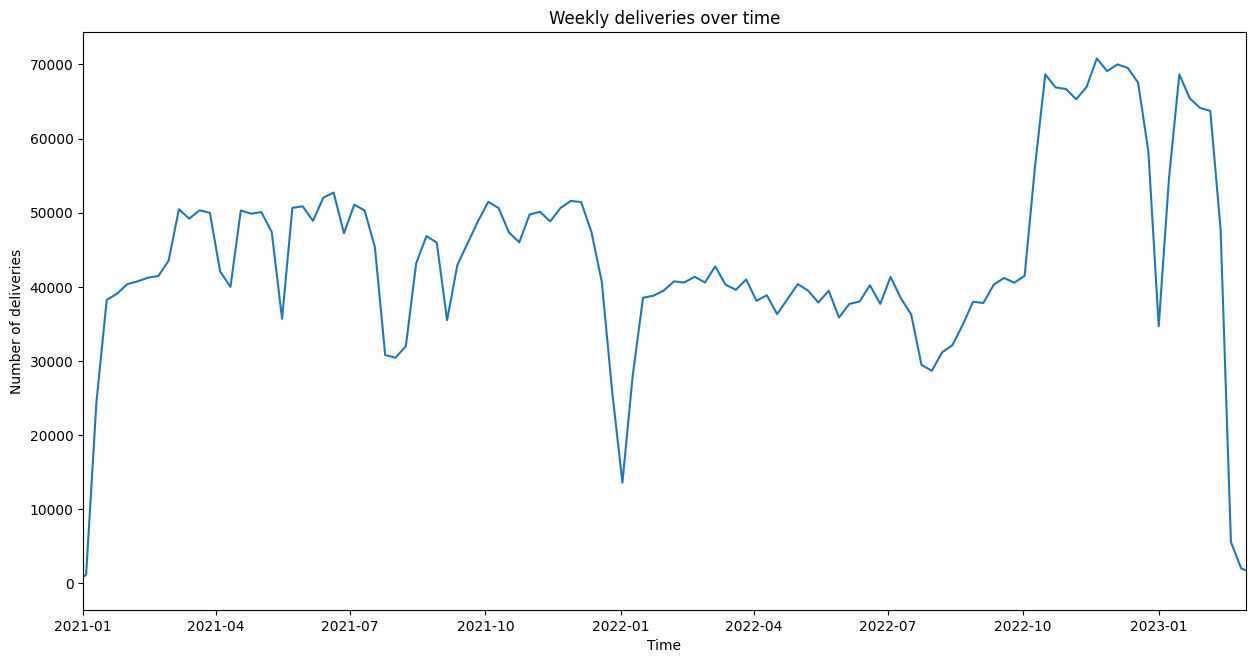

In [32]:
# Plotting WEEKLY number of deliveries
weekly_deliveries = df_final.groupby(pd.Grouper(key = 'StartRequestedDate', freq = 'W')).count()

# Setting figure size
fig = plt.figure(figsize = (15, 7.5))

# Plot the number of deliveries over time
plt.plot(weekly_deliveries.index, weekly_deliveries['BookingId'], label = 'Deliveries')

# Add axis labels and a title
plt.xlabel('Time')
plt.xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2023-03-01'), None)
plt.ylabel('Number of deliveries')
plt.title('Weekly deliveries over time')

# Show the plot
plt.show()

_Note_:   
- The dips at the beginning of 2021, 2022 and 2023 are due to low activity surrounding end/beginning of year and nothing to worry about for now   
- The sudden rise in 10/2022 is due to DDFS acquiring another company in 2020/2021; it seems like the operations of this new part of DFDS have only been fed into the data systems around the end of 2022

In [ ]:
# Plotting DAILY number of deliveries 
daily_deliveries = df_final.groupby(pd.Grouper(key = 'StartRequestedDate', freq = 'D')).count()

# Setting figure size
fig = plt.figure(figsize=(25, 5))

# Plot the number of deliveries over time
plt.plot(daily_deliveries.index, daily_deliveries['BookingId'], label = 'Deliveries')

# Add axis labels and a title
plt.xlabel('Time')
plt.xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2023-03-01'), None)
plt.ylabel('Number of deliveries')
plt.title('Daily deliveries over time')

# Show the plot
plt.show()

In [33]:
# "EndRequestedDate" Should look similar as the distribution of 'StartRequestedDate', but we'll check: 

same_date = df_final['StartRequestedDate'] == df_final['EndRequestedDate']

# Print the number of unique dates where delivery was planned and actually executed the same day

print(same_date.sum()) #2m deliveries are being picked up at the date they are supposed to 

2022981


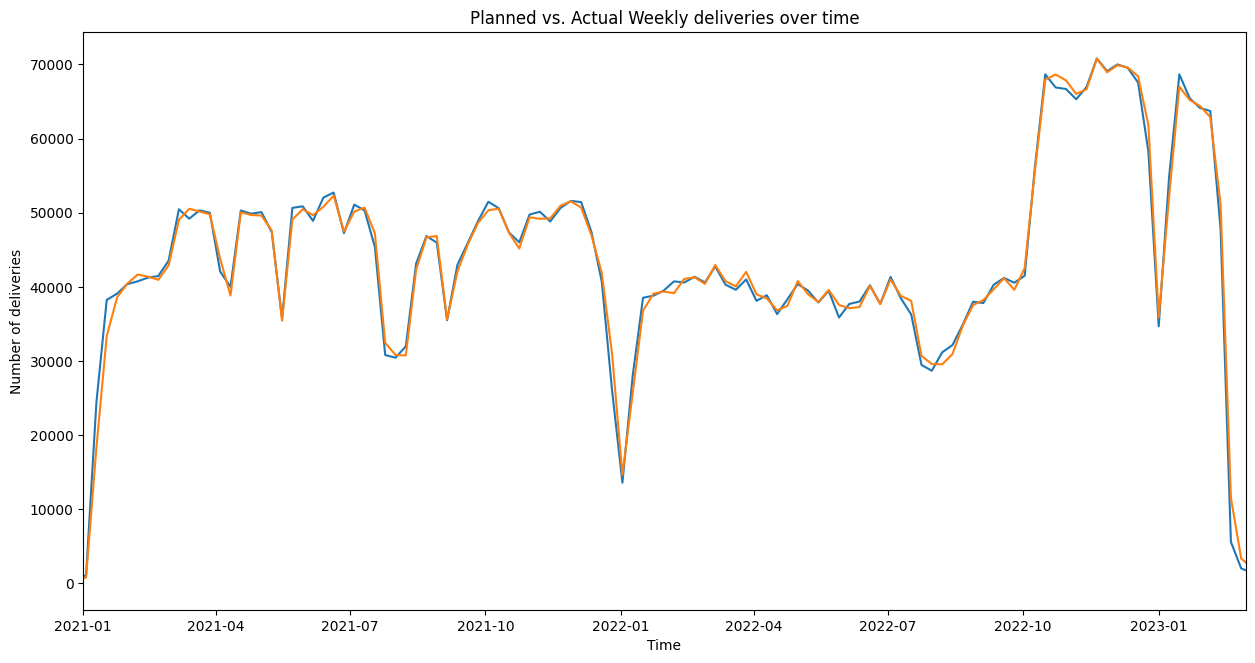

In [34]:
# Now checking if this is also visible in a graph

# Plotting WEEKLY number of deliveries
weekly_deliveries_planned = df_final.groupby(pd.Grouper(key = 'StartRequestedDate', freq = 'W')).count()
weekly_deliveries_actual = df_final.groupby(pd.Grouper(key = 'EndRequestedDate', freq = 'W')).count()

# Setting figure size
fig = plt.figure(figsize=(15, 7.5))

# Plot the number of deliveries over time
plt.plot(weekly_deliveries_planned.index, weekly_deliveries_planned['BookingId'], label = 'Planned Deliveries')
plt.plot(weekly_deliveries_actual.index, weekly_deliveries_actual['BookingId'], label = 'Actual Deliveries')

# Add axis labels and a title
plt.xlabel('Time')
plt.xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2023-03-01'), None)
plt.ylabel('Number of deliveries')
plt.title('Planned vs. Actual Weekly deliveries over time')

# Show the plot
plt.show()

4.7) "GrossWeight"

In [47]:
# = Weight of the delivery

df_final['GrossWeight'].describe()

# -> The distribution is extremely skewed by an unreasonably high maximum value

count    4.992586e+06
mean     5.447181e+03
std      4.502304e+05
min      0.000000e+00
25%      7.683000e+01
50%      5.782800e+02
75%      5.000000e+03
max      1.000024e+09
Name: GrossWeight, dtype: float64

Mean = 5447 kg, Min. = 0 kg, Max. = 1 bn kg (??)

In [48]:
# ~10% of the values is 0: 

df_final['GrossWeight'].value_counts()

0.00        490055
1.00        174846
24000.00     42680
20000.00     37648
25000.00     32723
             ...  
973.55           1
8725.40          1
2516.85          1
3895.02          1
719.65           1
Name: GrossWeight, Length: 333343, dtype: int64

In [49]:
# Calculate the percentage of deliveries with a weight of 0

num_zero_weight_deliveries = (df_final["GrossWeight"] == 0).sum()
total_deliveries = len(df_final)
percentage_zero_weight_deliveries = num_zero_weight_deliveries / total_deliveries * 100

# Print the percentage of deliveries with a weight of 0
print("Percentage of deliveries with weight 0: {:.2f}%".format(percentage_zero_weight_deliveries))

Percentage of deliveries with weight 0: 9.82%


_Note_:   
- Can we assume here that 9.82% of the deliveries are empty deliveries, so most likely empty trucks that are being relocated/"returning to home base"? 

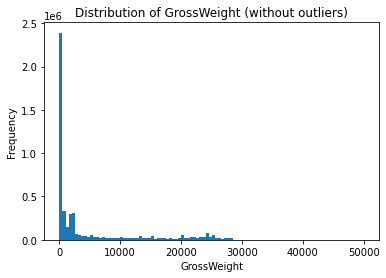

In [50]:
# Based on the previous findings, we plot the 'GrossWeight' distribution, excluding values >50,000

# Create a subset of the data 
subset = df_final[(df_final['GrossWeight'] < 50000)]

# Plot the histogram for GrossWeight feature
plt.hist(subset['GrossWeight'], bins = 100)
plt.xlabel('GrossWeight')
plt.ylabel('Frequency')
plt.title('Distribution of GrossWeight (without outliers)')
plt.show()

# Still skewed but maybe good enough

4.8) "Temperature"

In [51]:
# = Temperature of the delivery;
# -> 81.1% missing values, so careful with analyses

df_final['Temperature'].isna().sum() / len(df_final) * 100 

81.41464163060986

In [52]:
df_final['Temperature'].describe()

count    927890.000000
mean         -7.597398
std          15.614036
min         -40.000000
25%         -22.000000
50%          -5.000000
75%           0.000000
max          99.000000
Name: Temperature, dtype: float64

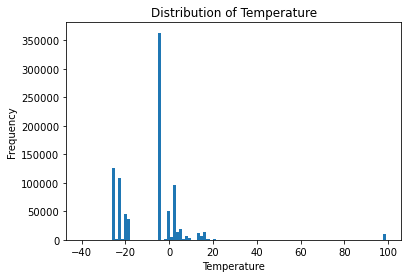

In [53]:
plt.hist(df_final['Temperature'], bins=100)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Distribution of Temperature')
plt.show()

**Note:**

There are two types of transports: Warm and cold. These have to be differentiated as cold transports have less reach. 
Find the creation of a new variable for frozen loads in "Feature Engineering" part below. 

4.9) "FromLatitude" and 4.10) "FromLongtitude" 

In [54]:
# = Information about the latitude and longitude points where a booking/delivery departs from 

# No analyses in here; see geographical visualization in Tableau
# Will be used to calculate distances below in feature engineering part

In [35]:
# Rename longitude column to vanish typo: 
df_final.rename(columns = {"FromLongtitude": "FromLongitude"}, inplace = True)

4.11) "FromCity"

In [63]:
# = City where a booking/delivery departs from 

# Irrelevant for analysis for now

4.12) "FromCountry"

In [64]:
# = Country where a booking/delivery departs from 

# There are quite some missing values in this variable due to the merge. 

df_final["FromCountry"].isna().sum()

88101

In [36]:
# Let's fill the gaps by reverse geocoding and get countries via the coordinates. 

# Define a function to get the country from the latitude and longitude columns

def get_from_country(row):
    if pd.isnull(row['FromCountry']):
        coordinates = (row['FromLatitude'], row['FromLongitude']), (0, 0)
        address = reverse_geocode.search(coordinates)[0]
        return address['country']
    else:
        return row['FromCountry']

In [37]:
# Apply the function

df_final['FromCountry'] = df_final.apply(get_from_country, axis = 1)

In [38]:
# Check again for missing values

df_final["FromCountry"].isna().sum()

0

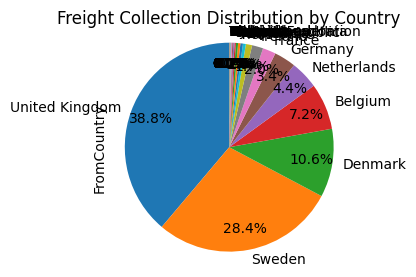

In [39]:
# Now let's visualize the variable

from_country = df_final['FromCountry'].value_counts()

from_country.plot(kind = 'pie', 
                  figsize = (3, 3), 
                  autopct = '%1.1f%%', 
                  startangle = 90,
                  pctdistance = 0.8,
                  labeldistance = 1.1)

plt.axis('equal')
plt.title('Freight Collection Distribution by Country')
plt.show()

4.13) "ToLatitude" and 4.14) "ToLongtitude"

In [49]:
# = Information about the latitude and longitude point where a booking/delivery is headed

# No analyses in here; see geographical visualization in Tableau
# Will be used to calculate distances below in feature engineering part

In [40]:
# Rename longitude column to vanish typo: 
df_final.rename(columns = {"ToLongtitude": "ToLongitude"}, inplace = True)

In [41]:
# Removing rows with latitude and longitude = 0.00 (due to human error) 
# --> because that corresponds to NullIsland and so the returned country = Ghana

df_final = df_final[df_final.FromLongitude != 0.000000]
df_final = df_final[df_final.ToLongitude != 0.000000]

4.15) "ToCity"

In [52]:
# = City where a booking/delivery is headed

# No deep dive needed for now

4.16) "ToCountry"

In [42]:
# = Country where a booking/delivery is headed

# There are quite some missing values in this variable due to the merge. 

df_final["ToCountry"].isna().sum()

54190

In [43]:
# Let's fill the gaps by reverse geocoding and get countries via the coordinates. 

# Define a function to get the country from the latitude and longitude columns
def get_to_country(row):
    if pd.isnull(row['ToCountry']):
        coordinates = (row['ToLatitude'], row['ToLongitude']), (0, 0)
        address=reverse_geocode.search(coordinates)[0]
        return address['country']
    else:
        return row['ToCountry']

In [44]:
# Applying the Function
df_final['ToCountry'] = df_final.apply(get_to_country, axis=1)

In [46]:
# Check again for missing values
df_final["ToCountry"].isna().sum()

0

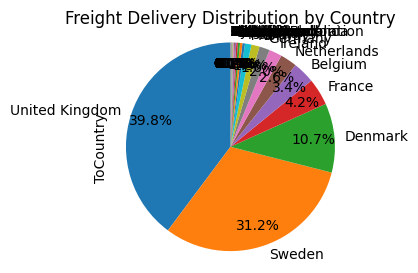

In [47]:
# Now let's visualize the variable

to_country = df_final['ToCountry'].value_counts()

to_country.plot(kind = 'pie', 
                  figsize = (3, 3), 
                  autopct = '%1.1f%%', 
                  startangle = 90,
                  pctdistance = 0.8,
                  labeldistance = 1.1)

plt.axis('equal')
plt.title('Freight Delivery Distribution by Country')
plt.show()

4.17) "FullLoadIndicator"

In [48]:
# = Indicates whether a load was "full"

# Checking loads counts

print('Nan:',df_final.FullLoadIndicator.isna().sum())
df_final.FullLoadIndicator.value_counts()

Nan: 584367


Y    2515263
N    1873974
Name: FullLoadIndicator, dtype: int64

In [49]:
# Binary encoding "FullLoadIndicator" from Y/N to 1/0

labelencoder = preprocessing.LabelEncoder()

df_final["FullLoadIndicator"] = df_final["FullLoadIndicator"].astype(str)
df_final["FullLoadIndicator"] = df_final["FullLoadIndicator"].map({'Y': 1, 'N': 0})

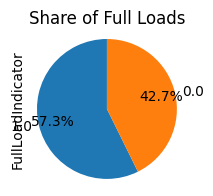

In [50]:
full_loads = df_final['FullLoadIndicator'].value_counts()

full_loads.plot(kind = 'pie', 
                            figsize = (2, 2), 
                            autopct = '%1.1f%%', 
                            startangle = 90,
                            pctdistance = 0.8,
                            labeldistance = 1.1)

plt.axis('equal')
plt.title('Share of Full Loads')
plt.show()

4.18) "EmptyBookingIndicator"

In [57]:
df_final['EmptyBookingIndicator'].value_counts()

N    4389237
Name: EmptyBookingIndicator, dtype: int64

In [51]:
# Binary encoding "EmptyBookingIndicator" from Y/N to 1/0

labelencoder = preprocessing.LabelEncoder()

df_final["EmptyBookingIndicator"] = df_final["EmptyBookingIndicator"].astype(str)
df_final["EmptyBookingIndicator"] = df_final["EmptyBookingIndicator"].map({'Y': 1, 'N': 0})

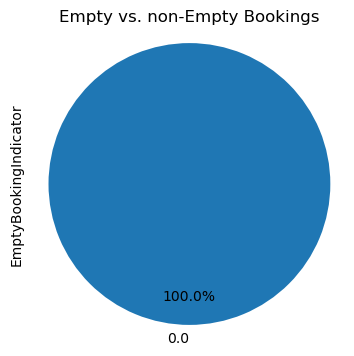

In [59]:
# = Gives information about "empty loads"; mostly trucks heading back to DFDS entities after a delivery

empty_booking = df_final['EmptyBookingIndicator'].value_counts()

empty_booking.plot(kind = 'pie', 
                            figsize = (4, 4), 
                            autopct = '%1.1f%%', 
                            startangle = 90,
                            pctdistance = 0.8,
                            labeldistance = 1.1)

plt.axis('equal')
plt.title('Empty vs. non-Empty Bookings')
plt.show()

# No empty bookings in new dataset?

In [60]:
# From Per's email:you can now guess if it is a full load (at least in the sense of being one truck doing a single collection and a single delivery), 
# Simply by counting the number of subbokings. E.g. if only one exists, it is full load.
no_load_info = df_final[df_final['EmptyBookingIndicator'].isna()]
len(no_load_info)

584367

In [ ]:
no_load_info.BookingId.value_counts()

In [ ]:
v = no_load_info.BookingId.value_counts()

In [ ]:
# These are the bookings without load indication appearing multiple times -->if we follow Per's suggestions, these should be NOT FULL LOAD 
# The remaining of 'no_load_info' df should be set as FULL LOAD

booking_multiple_lag = no_load_info[no_load_info.BookingId.isin(v.index[v.gt(1)])]
booking_multiple_lag.shape

In [ ]:
# Seems like all empty trips are not taken into account in the newest database 
# --> should we add these bookings from the og dataset or focus only on non-empty loads? 

print(df.EmptyBookingIndicator.isna().sum())
df.EmptyBookingIndicator.value_counts()

In [ ]:
empties=df[df['EmptyBookingIndicator']=='Y']
empties

4.19) "Customer Name"

In [52]:
# = the name of a customer 

# Counting unique number of customers:
df_final["Customer Name"].nunique()

12883

In [53]:
# Encoding Customer Name for anonymization purposes

df_final["Customer Name"] = labelencoder.fit_transform(df_final["Customer Name"])

df_final.head()

,BookingId,SubBookingName,FromLocation,ToLocation,StartRequestedDate,EndRequestedDate,GrossWeight,Temperature,FromLatitude,FromLongitude,FromCity,FromCountry,ToLatitude,ToLongitude,ToCity,ToCountry,FullLoadIndicator,EmptyBookingIndicator,Customer Name
0,7399574,A,33917,32289,2020-12-31,2020-12-31,0.0,NaN,53.51131,-1.12540,YORKSHIRE,United Kingdom,53.60475,-0.65636,SCUNTHORPE,United Kingdom,1.0,0.0,2966
1,7399575,A,9443,57716,2020-12-31,2020-12-31,0.0,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1.0,0.0,8183
2,7399576,A,9443,57716,2020-12-31,2020-12-31,0.0,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1.0,0.0,8183
3,7399577,A,5977,9831,2020-12-31,2020-12-31,0.0,NaN,53.77629,-1.52585,Leeds,United Kingdom,53.71874,-1.41235,YORKSHIRE,United Kingdom,0.0,0.0,4737
4,7399578,A,5977,3182,2020-12-31,2020-12-31,0.0,NaN,53.77629,-1.52585,Leeds,United Kingdom,55.87784,-3.65235,Bathgate,United Kingdom,1.0,0.0,4737


#### 5) Feature Engineering

5.1) "DomesticDelivery"

In [54]:
# = equals 1 if delivery is collected and delivered within the same country, 0 if otherwise

df_final['DomesticDelivery'] = (df_final['FromCountry'] == df_final['ToCountry']).astype(int)
df_final.head()

,BookingId,SubBookingName,FromLocation,ToLocation,StartRequestedDate,EndRequestedDate,GrossWeight,Temperature,FromLatitude,FromLongitude,FromCity,FromCountry,ToLatitude,ToLongitude,ToCity,ToCountry,FullLoadIndicator,EmptyBookingIndicator,Customer Name,DomesticDelivery
0,7399574,A,33917,32289,2020-12-31,2020-12-31,0.0,NaN,53.51131,-1.12540,YORKSHIRE,United Kingdom,53.60475,-0.65636,SCUNTHORPE,United Kingdom,1.0,0.0,2966,1
1,7399575,A,9443,57716,2020-12-31,2020-12-31,0.0,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1.0,0.0,8183,1
2,7399576,A,9443,57716,2020-12-31,2020-12-31,0.0,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1.0,0.0,8183,1
3,7399577,A,5977,9831,2020-12-31,2020-12-31,0.0,NaN,53.77629,-1.52585,Leeds,United Kingdom,53.71874,-1.41235,YORKSHIRE,United Kingdom,0.0,0.0,4737,1
4,7399578,A,5977,3182,2020-12-31,2020-12-31,0.0,NaN,53.77629,-1.52585,Leeds,United Kingdom,55.87784,-3.65235,Bathgate,United Kingdom,1.0,0.0,4737,1


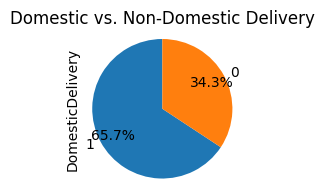

In [55]:
domestic_delivery = df_final['DomesticDelivery'].value_counts()

domestic_delivery.plot(kind = 'pie', 
                            figsize = (2, 2), 
                            autopct = '%1.1f%%', 
                            startangle = 90,
                            pctdistance = 0.8,
                            labeldistance = 1.1)

plt.axis('equal')
plt.title('Domestic vs. Non-Domestic Delivery')
plt.show()

5.2) "distance_haversine"

In [ ]:
# = Calculate haversine distance between delivery points to have an approximation for delivery distance 
# Is later gonna be replaced by more exact distance we calculate via API

def get_distance_h(lat1, lon1, lat2, lon2):
    pickup = (lat1, lon1)
    dropoff = (lat2, lon2)
    return hs.haversine(pickup, dropoff)

# Apply the function to dataframe
df_final['distance_haversine'] = df_final.apply(lambda row: get_distance_h(row['FromLatitude'], row['FromLongitude'], row['ToLatitude'], row['ToLongitude']), axis=1)
df_final.head()

In [ ]:
# df_final.to_csv('clean_data_distance.csv')

In [ ]:
df_final['distance_haversine'].describe()

Mean: 368 km 
Min.: 0 km
Max.: 8543 km

In [ ]:
# Plotting haversine distances

plt.hist(df_final["distance_haversine"], bins = 100)
plt.xlabel("Driving distance (km)")
plt.ylabel("Frequency")
plt.title("Distribution of delivery distances")
plt.show()

In [ ]:
# Plotting again, but this time exclusing all deliveries >2,500km, as they usually include sea travel 

subset = df_final[(df_final['distance_haversine'] < 2500)]

plt.hist(subset["distance_haversine"], bins = 250)
plt.xlabel("Driving distance (km)")
plt.ylabel("Frequency")
plt.title("Distribution of delivery distances")
plt.show()

5.3) "route_distance"

= We calculate the route length of a deliverie leveraging the Bing Maps API 

Knowing the distance of a delivery is crucial for us to now, as e-Trucks have a limited reach and charging stations have to be placed accordingly 

In [65]:
# The dataset has ~5 million rows. However, we don't want to make 5 million calls to the APi. 
# This is why we extract the unique routes first. 
# Every unique set of the four coordinate variables equals a unique route. 

# 1) Creating dataframe with only the coordinates 
coordinates_df = df_final[['FromLatitude', 'FromLongitude', 'ToLatitude', 'ToLongitude']]

# 2) dropping duplicate rows
coordinates_df = coordinates_df.drop_duplicates()

coordinates_df.head()

,FromLatitude,FromLongitude,ToLatitude,ToLongitude
0,53.51131,-1.12540,53.60475,-0.65636
1,53.50446,-2.84867,53.04612,-2.92787
3,53.77629,-1.52585,53.71874,-1.41235
4,53.77629,-1.52585,55.87784,-3.65235
5,53.50446,-2.84867,55.91412,-3.50947


In [66]:
# 3) The API Key is configured for educational uses and only allows for 50,000 API calls per day (for free).

# As 'coordinates_df' has ~163,000 rows, we need to divide this dataset into four parts before calling the API
# and then calculate the distances step-by-step

#coordinates_df_1 = coordinates_df.iloc[:45000]
#coordinates_df_2 = coordinates_df.iloc[45000:90000]
#coordinates_df_3 = coordinates_df.iloc[90000:135000]
#coordinates_df_4 = coordinates_df.iloc[135000:]

#print(len(coordinates_df_1), len(coordinates_df_2), len(coordinates_df_3), len(coordinates_df_4))

45000 45000 45000 27113


In [68]:
# # 3) Calculate distances using Bing Matrix API // Batches

# # Define Bing Maps API key
# api_key = 'AjjPXgFK_kEPapm4Aa71lVBC-OD0Cv--TxfWszdsMyVPAptZVtzAxV8a52UjW6Po'

# # Define the Bing Maps API endpoint
# url = 'https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix'

# # set the timeout value to 60 seconds to prevent errors from short-term connection issues
# # (default is 10 seconds)
# timeout = 60

# # Define a function to calculate distance between two locations using Bing Maps API
# def calculate_distances(rows):
#     distances = []
#     with requests.Session() as session:
#         for index, row in rows.iterrows():
#             # Define the request parameters
#             params = {
#                 'origins': f"{row['FromLatitude']},{row['FromLongitude']}",
#                 'destinations': f"{row['ToLatitude']},{row['ToLongitude']}",
#                 'travelMode': 'driving',
#                 'key': api_key
#             }
#             # Send the API request and get the response
#             response = session.get(url, params=params, timeout=timeout).json()
#             # Extract the distance from the response
#             distance = response['resourceSets'][0]['resources'][0]['results'][0]['travelDistance']
#             distances.append(distance)
#     return distances

# # Define the batch size
# batch_size = 100

# # Split the DataFrame into batches and calculate distances for each batch
# batches = [coordinates_df_1[i:i+batch_size] for i in range(0, len(coordinates_df_1), batch_size)]
# distances = []
# for batch in batches:
#     distances += calculate_distances(batch)

# # Add the distances to the DataFrame
# coordinates_df_1['route_distance'] = distances

# # Print the updated DataFrame
# print(coordinates_df_1.head())

# # Save the DataFrame as a CSV file
# coordinates_df_1.to_csv('coordinates_df_1.csv', index=False)


ReadTimeout: HTTPSConnectionPool(host='dev.virtualearth.net', port=443): Read timed out. (read timeout=60)

In [59]:
# Concatenating together the single csv files from the API calls
import os 
# set working directory to where the CSV files are located
os.chdir('/Users/jangaydoul/Desktop/Copenhagen Business School/4. Semester :: Thesis/03_Data/csvs')

# initialize an empty dataframe to hold the concatenated data
coordinates_df_vf = pd.DataFrame()

# loop through each CSV file and append its data to the dataframe
for file in os.listdir():
    if file.endswith('.csv'):
        temp_df = pd.read_csv(file)
        coordinates_df_vf = pd.concat([coordinates_df_vf, temp_df])

# export the concatenated data to a new CSV file
coordinates_df_vf.to_csv('coordinates_df_vf.csv', index=False)

In [60]:
# 4) We create a [route: distance] dictionary in order to then map the distances from the unique routes 
# to the full dataset:

route_distances_dict = coordinates_df_vf.set_index(['FromLatitude', 'FromLongitude', 'ToLatitude', 'ToLongitude'])['route_distance'].to_dict()

In [62]:
# Check out if dictionare setup worked
first_few = list(route_distances_dict.items())[:10]

# print the first few entries
print(first_few)

[((50.63656, 4.78251, 63.44178, 10.40893), 2004.311), ((56.20318, 14.8734, 57.42278, 15.06204), 160.384), ((57.73572, 11.98862, 56.16157, 15.58364), 376.025), ((60.71076, 10.60526, 51.00683, -0.42949), 1991.237), ((57.73572, 11.98862, 56.21754, 15.27024), 348.243), ((52.29191, 0.3908, 52.59905, -2.11051), 203.926), ((56.73379, 15.98266, 53.46811, -2.30989), 1870.927), ((51.80442, -2.73111, 56.65121, 12.90138), 1639.319), ((54.81511, -6.71169, 52.59421, -1.21486), 665.551), ((54.81511, -6.71169, 51.8658, 0.87254), 827.731)]


In [64]:
# 5) Map the route distances to the original DataFrame

df_final['route_distance'] = df_final.set_index(['FromLatitude', 'FromLongitude', 'ToLatitude', 'ToLongitude']).index.map(route_distances_dict)

# Check the updated DataFrame
df_final.head()

,BookingId,SubBookingName,FromLocation,ToLocation,StartRequestedDate,EndRequestedDate,GrossWeight,Temperature,FromLatitude,FromLongitude,FromCity,FromCountry,ToLatitude,ToLongitude,ToCity,ToCountry,FullLoadIndicator,EmptyBookingIndicator,Customer Name,DomesticDelivery,route_distance
0,7399574,A,33917,32289,2020-12-31,2020-12-31,0.0,NaN,53.51131,-1.12540,YORKSHIRE,United Kingdom,53.60475,-0.65636,SCUNTHORPE,United Kingdom,1.0,0.0,2966,1,46.346
1,7399575,A,9443,57716,2020-12-31,2020-12-31,0.0,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1.0,0.0,8183,1,78.192
2,7399576,A,9443,57716,2020-12-31,2020-12-31,0.0,NaN,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1.0,0.0,8183,1,78.192
3,7399577,A,5977,9831,2020-12-31,2020-12-31,0.0,NaN,53.77629,-1.52585,Leeds,United Kingdom,53.71874,-1.41235,YORKSHIRE,United Kingdom,0.0,0.0,4737,1,17.733
4,7399578,A,5977,3182,2020-12-31,2020-12-31,0.0,NaN,53.77629,-1.52585,Leeds,United Kingdom,55.87784,-3.65235,Bathgate,United Kingdom,1.0,0.0,4737,1,369.340


In [65]:
df_final['route_distance'].isna().sum()

382

 5.4) "frozen_load"

In [66]:
# We want to know whether a load is frozen or not, as this has major implications on the reach of the truck. 
# That's why we binary encode the "temperature" feature 

# Create the new "frozen_load" column using numpy.where
df_final['frozen_load'] = np.where(df_final['Temperature'] < 0, 1, 0)

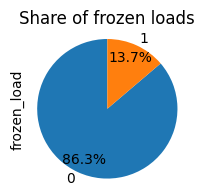

In [67]:
frozen_load = df_final['frozen_load'].value_counts()

frozen_load.plot(kind = 'pie', 
                        figsize = (2, 2), 
                        autopct = '%1.1f%%', 
                        startangle = 90,
                        pctdistance = 0.8,
                        labeldistance = 1.1)

plt.axis('equal')
plt.title('Share of frozen loads')
plt.show()

#### Final touches 

- Now that pre-processing is done, there are two final steps: 

1) Re-order columns so everything is in a purposeful order
2) Create dataset only with full loads (makes up 92% of original dataset anyways, but still) 


In [68]:
# Check missing values again to see if everything has been taken care of 
df_final.isna().sum()

BookingId                      0
SubBookingName                 0
FromLocation                   0
ToLocation                     0
StartRequestedDate           338
EndRequestedDate               0
GrossWeight                    0
Temperature              4048923
FromLatitude                   0
FromLongitude                  0
FromCity                       0
FromCountry                    0
ToLatitude                     0
ToLongitude                    0
ToCity                         2
ToCountry                      0
FullLoadIndicator         584367
EmptyBookingIndicator     584367
Customer Name                  0
DomesticDelivery               0
route_distance               382
frozen_load                    0
dtype: int64

In [ ]:
# Create df_full that only contains full loads 

#
#

In [69]:
columns = list(df_final.columns)
print(columns)

['BookingId', 'SubBookingName', 'FromLocation', 'ToLocation', 'StartRequestedDate', 'EndRequestedDate', 'GrossWeight', 'Temperature', 'FromLatitude', 'FromLongitude', 'FromCity', 'FromCountry', 'ToLatitude', 'ToLongitude', 'ToCity', 'ToCountry', 'FullLoadIndicator', 'EmptyBookingIndicator', 'Customer Name', 'DomesticDelivery', 'route_distance', 'frozen_load']


In [70]:
# Order columns of dataset meaningful 

# Define the desired order of columns
column_order = ['BookingId', 'SubBookingName', 'Customer Name', 'StartRequestedDate', 'EndRequestedDate', 'FromLocation', 'ToLocation', 'FromLatitude', 'FromLongitude', 'FromCity', 'FromCountry', 'ToLatitude', 'ToLongitude', 'ToCity', 'ToCountry', 'DomesticDelivery', 'route_distance', 'FullLoadIndicator', 'EmptyBookingIndicator','GrossWeight', 'Temperature', 'frozen_load']

# Use the reindex() method to reorder the columns in the dataframe
df_final = df_final.reindex(columns = column_order)

In [71]:
# Look at final dataset

df_final.head(10)

,BookingId,SubBookingName,Customer Name,StartRequestedDate,EndRequestedDate,FromLocation,ToLocation,FromLatitude,FromLongitude,FromCity,FromCountry,ToLatitude,ToLongitude,ToCity,ToCountry,DomesticDelivery,route_distance,FullLoadIndicator,EmptyBookingIndicator,GrossWeight,Temperature,frozen_load
0,7399574,A,2966,2020-12-31,2020-12-31,33917,32289,53.51131,-1.12540,YORKSHIRE,United Kingdom,53.60475,-0.65636,SCUNTHORPE,United Kingdom,1,46.346,1.0,0.0,0.0,NaN,0
1,7399575,A,8183,2020-12-31,2020-12-31,9443,57716,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1,78.192,1.0,0.0,0.0,NaN,0
2,7399576,A,8183,2020-12-31,2020-12-31,9443,57716,53.50446,-2.84867,Liverpool,United Kingdom,53.04612,-2.92787,Wrexham,United Kingdom,1,78.192,1.0,0.0,0.0,NaN,0
3,7399577,A,4737,2020-12-31,2020-12-31,5977,9831,53.77629,-1.52585,Leeds,United Kingdom,53.71874,-1.41235,YORKSHIRE,United Kingdom,1,17.733,0.0,0.0,0.0,NaN,0
4,7399578,A,4737,2020-12-31,2020-12-31,5977,3182,53.77629,-1.52585,Leeds,United Kingdom,55.87784,-3.65235,Bathgate,United Kingdom,1,369.340,1.0,0.0,0.0,NaN,0
5,7399579,A,8054,2020-12-31,2020-12-31,9320,37777,53.50446,-2.84867,Liverpool,United Kingdom,55.91412,-3.50947,LIVINGSTON,United Kingdom,1,362.516,0.0,0.0,0.0,NaN,0
6,7399580,A,4737,2020-12-31,2020-12-31,5977,29662,53.77629,-1.52585,Leeds,United Kingdom,53.58155,-1.52633,Barnsley,United Kingdom,1,27.685,0.0,0.0,0.0,NaN,0
7,7399581,A,4737,2020-12-31,2020-12-31,5977,11828,53.77629,-1.52585,Leeds,United Kingdom,53.62632,-1.35656,Pontefract,United Kingdom,1,29.779,0.0,0.0,0.0,NaN,0
8,7399582,A,8183,2020-12-30,2020-12-31,37964,21225,53.84792,-2.19863,Colne,United Kingdom,53.50446,-2.84867,Liverpool,United Kingdom,1,79.157,1.0,0.0,0.0,NaN,0
9,7399583,A,7658,2020-12-31,2020-12-31,9320,78484,53.50446,-2.84867,Liverpool,United Kingdom,53.51131,-1.12540,Doncaster,United Kingdom,1,167.201,1.0,0.0,0.0,NaN,0


In [72]:
# Saving df_final
df_final.to_csv('df_final.csv', index=False)